In [1]:
# Import Necessary Libraries
import warnings  # To suppress warnings
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis
import seaborn as sns  # For advanced visualizations
import matplotlib.pyplot as plt  # For plotting basic visualizations
import os  # For file handling
# Suppress warnings
warnings.filterwarnings("ignore")

import scipy.optimize as opt
from statsmodels.tsa.seasonal import seasonal_decompose


In [ ]:
# Load cleaned dataset resulted from EDA
df = pd.read_csv("cleaned_SC_dataset.csv")

df.head()

,Monthly_Demand,Lead_Time,Stock_Level,Supplier_Reliability,Seasonality_Factor,Year,Month,Day,Weekday,Quarter,Device_Type_Monitoring,Device_Type_Surgical,Device_Type_Therapeutic
0,565,18,608,0.81,1.007333,2018,1,1,3,1,0.0,1.0,0.0
1,480,12,497,0.91,0.975088,2018,1,3,5,1,0.0,0.0,1.0
2,599,9,646,0.83,1.028933,2018,1,5,7,1,0.0,1.0,0.0
3,478,18,500,0.82,1.044259,2018,1,5,7,1,1.0,0.0,0.0
4,516,12,537,0.72,1.022368,2018,1,6,1,1,1.0,0.0,0.0


Now, I have a problem with seasonality factor. It's correlated to the target and I want to include it in my model's features. But, expecting the user to provide the seasonality_factor makes deployment inconvenient.So, I need a way to handle it internally.

There are 3 ways to handle it:-

1 - Model Seasonality Factor Separately.
Since seasonality_factor is derived from seasonal patterns, I can create a separate model to predict it based on the date, then use the predicted value as an input to my main XGBoost model.

2 - Engineer Seasonality Factor as a Fixed Function.
If seasonality_factor follows a fixed pattern, I can replace it with a mathematical function based on month, quarter, or other time features.

3 - Use One Model That Learns Seasonality Implicitly.
Instead of using seasonality_factor explicitly, I can train XGBoost without it, relying on time features (year, month, quarter, etc.) to learn seasonality patterns.

Now, from EDA notebook, the decomposition plot shows a clear seasonal pattern that repeats consistently over time. Given this, the best approach would be:Fit a Sinusoidal Function.
That's what I'm going to implement in the next few steps.

In [3]:
# If seasonality_factor is available, take its monthly average

seasonality_avg = df.groupby("Month")["Seasonality_Factor"].mean().reset_index()

# Normalize the factor (scale between 0 and 1 or a reasonable range)

seasonality_avg["Seasonality_Factor"] = (seasonality_avg["Seasonality_Factor"] - seasonality_avg["Seasonality_Factor"].min()) / \
                                        (seasonality_avg["Seasonality_Factor"].max() - seasonality_avg["Seasonality_Factor"].min())


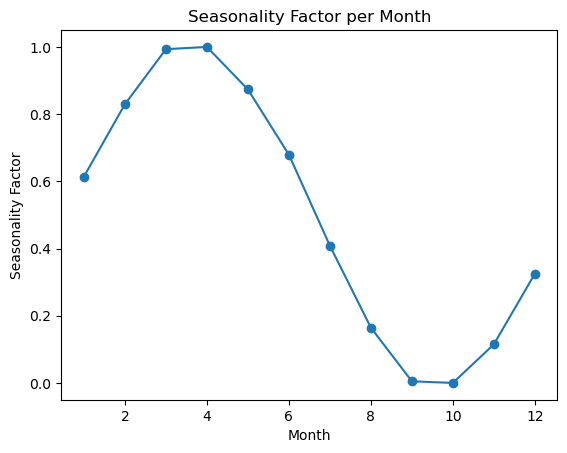

In [4]:
# Plot to check
plt.plot(seasonality_avg["Month"], seasonality_avg["Seasonality_Factor"], marker='o')
plt.xlabel("Month")
plt.ylabel("Seasonality Factor")
plt.title("Seasonality Factor per Month")
plt.show()

Fitted Parameters: a=-0.5119, b=0.5208, c=2.8289, d=0.5004


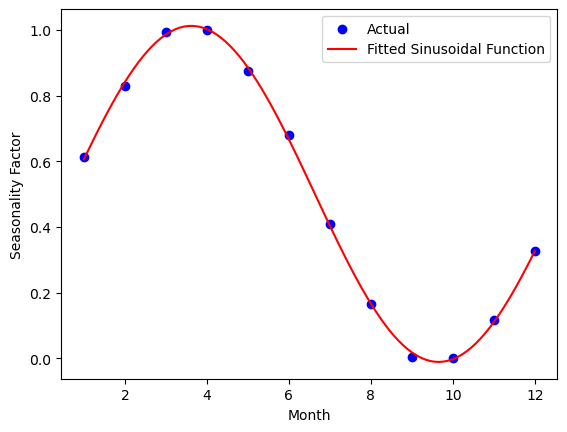

In [5]:
# Define a sinusoidal function
def sin_func(x, a, b, c, d):
    return a * np.sin(b * x + c) + d

# Fit the function to the seasonality data
params, _ = opt.curve_fit(sin_func, seasonality_avg["Month"], seasonality_avg["Seasonality_Factor"])

# Extract fitted parameters
a, b, c, d = params
print(f"Fitted Parameters: a={a:.4f}, b={b:.4f}, c={c:.4f}, d={d:.4f}")

# Plot the fitted function against actual values
x_values = np.linspace(1, 12, 100)  # Smooth line
y_values = sin_func(x_values, a, b, c, d)

plt.scatter(seasonality_avg["Month"], seasonality_avg["Seasonality_Factor"], label="Actual", color="blue")
plt.plot(x_values, y_values, label="Fitted Sinusoidal Function", color="red")
plt.xlabel("Month")
plt.ylabel("Seasonality Factor")
plt.legend()
plt.show()

In [6]:
# this is my target function which I'll use later to extract seasonality from the user input date.

def compute_seasonality_factor(month):
    return sin_func(month, -0.5119, 0.5208, 2.8289, 0.5004)


In [ ]:
# modify dataset with new seasonality factor column

df["computed_seasonality_factor"] = df["Month"].apply(compute_seasonality_factor)

# the resulted column from the last step included smaller values than their corresponding values in the original seasonality_factor column which I'm trying to model
# one solution for this problem is to rescale the computed seasonality factor column values to the original column:-

# Compute min and max of original seasonality factor
min_original = df["Seasonality_Factor"].min()
max_original = df["Seasonality_Factor"].max()

# Rescale computed seasonality factor
def rescale_factor(value):
    return min_original + (value - np.min(value)) * (max_original - min_original) / (np.max(value) - np.min(value))

df["computed_seasonality_factor"] = rescale_factor(df["computed_seasonality_factor"])

df.head(10)


,Monthly_Demand,Lead_Time,Stock_Level,Supplier_Reliability,Seasonality_Factor,Year,Month,Day,Weekday,Quarter,Device_Type_Monitoring,Device_Type_Surgical,Device_Type_Therapeutic,computed_seasonality_factor
0,565,18,608,0.81,1.007333,2018,1,1,3,1,0.0,1.0,0.0,1.020848
1,480,12,497,0.91,0.975088,2018,1,3,5,1,0.0,0.0,1.0,1.020848
2,599,9,646,0.83,1.028933,2018,1,5,7,1,0.0,1.0,0.0,1.020848
3,478,18,500,0.82,1.044259,2018,1,5,7,1,1.0,0.0,0.0,1.020848
4,516,12,537,0.72,1.022368,2018,1,6,1,1,1.0,0.0,0.0,1.020848
5,436,24,451,0.85,0.956736,2018,1,6,1,1,0.0,0.0,1.0,1.020848
6,453,27,482,0.93,0.979640,2018,1,8,3,1,0.0,0.0,0.0,1.020848
7,632,7,670,0.71,1.021287,2018,1,9,4,1,1.0,0.0,0.0,1.020848
8,499,3,519,0.91,0.988919,2018,1,11,6,1,0.0,1.0,0.0,1.020848
9,546,28,587,0.93,0.981986,2018,1,12,7,1,0.0,0.0,1.0,1.020848


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error


# Define features and target
features = ["Year", "Month", "Day", "computed_seasonality_factor"]

X = df[features]
y = df['Monthly_Demand']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
# Model 1: Random Forest

from sklearn.metrics import r2_score

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred_rf)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2 = r2_score(y_test, y_pred_rf)

# Print metrics
print(f"MAE: {mae}, RMSE: {rmse}, R-squared: {r2}")


MAE: 97.41243808490123, RMSE: 127.11517531061119, R-squared: 0.9923260811414689


In [10]:
# Model 2: XGBoost

xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred_xgb)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2 = r2_score(y_test, y_pred_xgb)

# Print metrics
print(f"MAE: {mae}, RMSE: {rmse}, R-squared: {r2}")


MAE: 87.0965496673584, RMSE: 111.87714190998433, R-squared: 0.9940556287765503


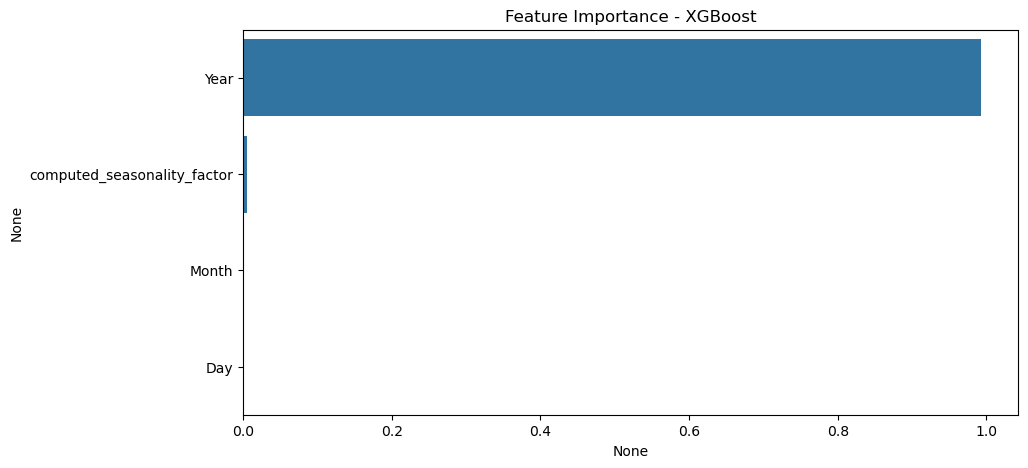

In [11]:
# Feature Importance

features = ["Year", "Month", "Day", "computed_seasonality_factor"]


feature_importances = pd.Series(xgb_model.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title("Feature Importance - XGBoost")
plt.show()

In [12]:
# Remove Year from features
features_reduced = [col for col in features if col != "Year"]

X_train_reduced = X_train[:, [features.index(col) for col in features_reduced]]
X_test_reduced = X_test[:, [features.index(col) for col in features_reduced]]

# Train new model
xgb_model_reduced = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model_reduced.fit(X_train_reduced, y_train)

# Predictions
y_pred_xgb_reduced = xgb_model_reduced.predict(X_test_reduced)

# Compare performance

print("Original XGBoost MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("Reduced XGBoost MAE:", mean_absolute_error(y_test, y_pred_xgb_reduced))
print("Original XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("Reduced XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb_reduced)))
print("Original XGBoost R-squared:", r2_score(y_test, y_pred_xgb))
print("Reduced XGBoost R-squared:", r2_score(y_test, y_pred_xgb_reduced))

Original XGBoost MAE: 87.0965496673584
Reduced XGBoost MAE: 1269.7753020019532
Original XGBoost RMSE: 111.87714190998433
Reduced XGBoost RMSE: 1470.5906295869333
Original XGBoost R-squared: 0.9940556287765503
Reduced XGBoost R-squared: -0.027083992958068848


As reducing the Year Feature resulted in a corrupted model, 'Year' feature wasn't overfitting, it's just high importance in my model. So, I'll keep it

note that: I'd walked through the same steps but for "Stock_Level" before dropping it from my features. 
and it was overfitting as it was highly correlated with the target (~ 1) plus , it dominated the feature importance chart.
that's why I retrained a reduced model without it and the model performance remained nearly the same.

In [ ]:
# Save the Models and Scaler

import joblib

joblib.dump(rf_model, 'rf_model.pkl')

joblib.dump(xgb_model, 'xgb_model.pkl')

joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']